# 3 Build a custom dataloader

In [19]:
from pathlib import Path
import numpy as np
from typing import Iterator, Tuple, List
import mads_datasets
mads_datasets.__version__

'0.3.14'

The problem with images is that the size grows pretty fast.

In [20]:
image_size = (180, 180, 3)

for i in [1, 10, 100]:
    size = (i, ) + image_size
    X = np.zeros(size)
    size_byte = X.nbytes
    print(f"Size for {i} images: {size_byte / (2**20)} MB")

Size for 1 images: 0.7415771484375 MB
Size for 10 images: 7.415771484375 MB
Size for 100 images: 74.15771484375 MB


Imagine what would happen if you actually have a million images! And no, the answer to this
is not "just get more RAM in the cloud". You actually don't need to store everything at
the same time in memory, right? So we will use the dataloader pattern to fix this problem. 

Tensorflow has a nice [collection of datasets](https://www.tensorflow.org/datasets) for machine learning tasks. Let's download the 'flower_photos' dataset. We will use that dataset for image classification later on. 

In [21]:
from mads_datasets import DatasetFactoryProvider, DatasetType
flowersfactory = DatasetFactoryProvider.create_factory(DatasetType.FLOWERS)
flowersfactory.download_data()


2024-11-27 18:08:54.085 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/flowers


In [22]:
image_folder = flowersfactory.subfolder
print(image_folder)

/home/azureuser/.cache/mads_datasets/flowers


Let's  build a datagenerator from scratch; even though there are a lot of libraries (tensorflow, pytorch, trax) that provide datagenerators for images, it is a usefull practice to learn how the inside works. 

Eventually you will encounter a task were you will need to read in data from disk, and it is always usefull if you know how to adapt to a custom case. First step is to list all files in the directory:

In [23]:
def walk_dir(path: Path) -> Iterator:
    """loops recursively through a folder

    Args:
        path (Path): folder to loop trough. If a directory
            is encountered, loop through that recursively.

    Yields:
        Generator: all paths in a folder and subdirs.
    """

    for p in Path(path).iterdir():
        if p.is_dir():
            yield from walk_dir(p)
            continue
        # resolve works like .absolute(), but it removes the "../.." parts
        # of the location, so it is cleaner
        yield p.resolve()

Note that the first file is a .txt file, so we will need to filter that.

In [24]:
paths = walk_dir(image_folder)
file1 = next(paths)
file2 = next(paths)
file1, file2

(PosixPath('/home/azureuser/.cache/mads_datasets/flowers/flower_photos/roses/16670921315_0fc48d7ab2_n.jpg'),
 PosixPath('/home/azureuser/.cache/mads_datasets/flowers/flower_photos/roses/14747962886_2bff6bb323_m.jpg'))

So, we now have a generator of paths in the directory. We can use a path to load an image from disk.
The stucture that is often used for storing images is to have subfolders that indicate a label. 
This is an easy way to create a dataset by a human (just drag and drop the images in the right folder to label them).

If the photo is inside the `tulips` subfolder, the class label should be `tulips`

In [25]:
from PIL import Image
file = next(paths)
img = Image.open(file)

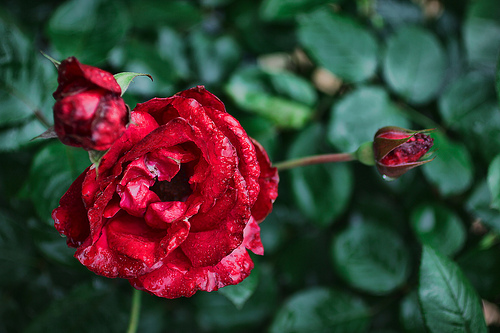

In [26]:
img.show()

The `iter_valid_paths` function pulls all files, strips the corrects suffixes (we only want images), retrieves the classnames by gathering the names of the subfolders, and returns both

In [27]:
# lets have a look at the available file types
from mads_datasets.settings import FileTypes
for ft in FileTypes:
    print(ft)

FileTypes.JPG
FileTypes.PNG
FileTypes.TXT
FileTypes.ZIP
FileTypes.TGZ
FileTypes.TAR
FileTypes.GZ
FileTypes.PT
FileTypes.CSV
FileTypes.PARQ


In [28]:
def iter_valid_paths(path: Path, formats: List[FileTypes]) -> Tuple[Iterator, List[str]]:
    # gets all files in folder and subfolders
    walk = walk_dir(path)

    # retrieves foldernames as classnames
    class_names = [subdir.name for subdir in path.iterdir() if subdir.is_dir()]

    # keeps only specified formats
    formats_ = [f.value for f in formats]
    paths = (path for path in walk if path.suffix in formats_)
    return paths, class_names

In [29]:
formats = [FileTypes.JPG]
paths, class_names = iter_valid_paths(
    path = image_folder / "flower_photos",
    formats=formats
)

In [30]:
next(paths), class_names

(PosixPath('/home/azureuser/.cache/mads_datasets/flowers/flower_photos/roses/16670921315_0fc48d7ab2_n.jpg'),
 ['roses', 'sunflowers', 'daisy', 'tulips', 'dandelion'])

And, last, we need the `load_image` function.

While there are multiple libraries available to load images (`pyvips`, `PIL`) the functions from `tensorflow` are the fastest for the sequence of tasks:
- load image from disk
- decode into an array of numbers
- resize the image to a fixed size
- cast to `numpy` array

In [31]:
imgpath = next(paths)
newsize = (150, 150)
img_ = Image.open(imgpath).resize(newsize, Image.LANCZOS)

In [32]:
img = np.asarray(img_)
img.shape

(150, 150, 3)

In [33]:
def load_image(
    path: Path, image_size: Tuple[int, int]
) -> np.ndarray:
    # load file
    img_ = Image.open(path).resize(image_size, Image.LANCZOS)
    return np.asarray(img_)

In [34]:
%timeit load_image(file, image_size=(180, 180))

5.73 ms ± 37.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
file = next(paths)
img = load_image(file, (180, 180))
type(img), img.shape

(numpy.ndarray, (180, 180, 3))

Lets have a look at the image we loaded

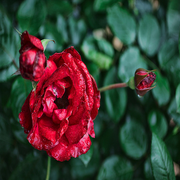

In [36]:
Image.fromarray(img.astype(np.uint8))

With this, we can construct our own data generator, using the design pattern we looked at in lesson 2.

- We gather all the paths to files
- We shuffle the index_list 
- For the range of `batchsize`, we use the `index_list[index]` design pattern to gather a random batch
- label name is extacted from the subfolder name

We can time this, and it is fast enough, considering we have a batchsize of 32; I clocked 2.68ms for a single image, so that would give us about 86ms for just the loading of the 32 images from disk. Depending on things like my cpu temperature, I get around 98ms for a batch. The additional 22ms for resizing, decoding and casting to numpy for 32 images comes down to about 0.7ms per image.

In [37]:
x = np.transpose(img, (2, 0, 1))
x.shape

(3, 180, 180)

The basis of most `DataSet` objects in libraries is that the `DataSet` has three methods defined:
- `__init__` to initialize the object
- `__len__` to return the length of the dataset
- `__getitem__` to return a batch of data

How the lenght of your dataset is defined might vary slightly, but in general it means the number of observations in your dataset (eg the number of images, or texts, etc).
The `__getitem__` method is used to return a batch of data. This is the method that is called when you use the `[]` operator on the dataset object.

A minimal example would look like this:


In [38]:
import numpy as np

class MyDataSet:
    def __init__(self, data: np.ndarray, targets: np.ndarray):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

We could make this a bit more specific. Let's say we want to create a template that:
- receives a list of files 
- the files are processed by a function `process_data`
- the dataset will be a list, eg a list of tuples

In [39]:
import random

class BaseDataset:
    """The main responsibility of the Dataset class is to load the data from disk
    and to offer a __len__ method and a __getitem__ method
    """

    def __init__(self, paths: List[Path]) -> None:
        self.paths = paths
        random.shuffle(self.paths)
        self.dataset: list = []
        self.process_data()

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> Tuple:
        return self.dataset[idx]

    def process_data(self) -> None:
        # note we raise an error here. This is a template, and we want to force
        # the implementation of this function to be done in the child class
        raise NotImplementedError

class ImgDataset(BaseDataset):
    def __init__(self, paths, class_names, img_size):
        self.img_size = img_size
        self.class_names = class_names
        super().__init__(paths) # this will call the __init__ method of the parent class
        # and will shuffle the paths, create .dataset and call process_data

    def process_data(self) -> None:
        # we dont need to reimplement all the __len__ and __getitem__ methods; they are in the
        # parent class. Only thing we need to bother is the process_data method, and some
        # additional arguments in the __init__ method
        for file in self.paths:
            img = load_image(file, self.img_size)
            x = np.transpose(img, (2, 0, 1))
            y = self.class_names.index(file.parent.name)
            self.dataset.append((x, y))


Note that in this implementation, all the images are loaded into memory. Sometimes, that is not possible, and you will need to load the images on the fly. In that case, you should change the `__getitem__` method to load the image from disk, and the process_data method should not load the images, but only do preprocessing that is not dependent on the image itself (if that is necessary at all)

In [40]:
paths, class_names = iter_valid_paths(
    path = image_folder / "flower_photos",
    formats = [FileTypes.JPG],
)
dataset = ImgDataset([*paths], class_names, img_size=(150, 150))

In [41]:
X, y = dataset[0]
X.shape, y

((3, 150, 150), 2)

All these methods are wrapped together inside the datasetfactory:

In [42]:
datasets = flowersfactory.create_dataset()
train = datasets["train"]

2024-11-27 18:09:29.309 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/flowers


In [43]:
len(train)

2936

In [44]:
x, y = train[1]
x.shape, y

(torch.Size([3, 224, 224]), tensor(3))

the batch is now a pair of (img, label) tuples. However, we want to untangle a certain amount of them into a list of images and a list of labels.
Think of this as unzipping a zipper. Weirdly enough, in python we use the same command for this as we would use to create the pairs.

In [45]:
def batch_processor(batch):
    X, Y = zip(*batch)
    return np.stack(X), np.array(Y)

In [46]:
batch = []
for i in range(10):
    X, y = train[i]
    batch.append((X, y))
# at this point, we have [(X, y), (X, y), ...]
# what we want is: (X, X, ...), (y, y, ...)

In [47]:
X, y = batch_processor(batch)
X.shape, y.shape

((10, 3, 224, 224), (10,))

You can see this works as expected: we transformed our list of `[(X, y), (X, y), ...]` into a batched (X, X, X, ...) and (y, y, y, ...) pair.
Note the dimensions: we have a batch of 10 images, each image (3, 224, 224) and for the labels we have shape (10,), meaning this is a vector with ten elements.

Now, lets combine this in the datastreamer:

In [48]:
from mads_datasets.base import BaseDatastreamer
streamer = BaseDatastreamer(
    dataset=train,
    batchsize=32,
    preprocessor=batch_processor
)

In [49]:
gen = streamer.stream()
X, y = next(gen)
X.shape, y.shape

((32, 3, 224, 224), (32,))

The streamer will shuffle the index list every epoch, and use that to get the images from the dataset.
Our streamer has selected 32 of those pairs and recombined them into a batch of 32 images, sized 150x150, with 3 channels (for colour). The labels are just an array of 32 labels.

Our datastreamer will provide us with an endless stream of shuffled batches of images and labels, which we can use to train our model.

In [50]:
%timeit X, y = next(gen)

4.97 ms ± 57.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
